In [155]:
%matplotlib inline

import json
import os

from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn import cluster
from sklearn import manifold
from sklearn import preprocessing
from scipy.spatial.distance import cdist
import numpy as np
import math
import time
import pandas as pd

data = []
fileNames = []
fileSize = []

###############################################
# Read Documents
###############################################

for root, dirs, files in os.walk("wiki-docs-large"):
    for filePath in files:
        if filePath.endswith(".txt"):
            with open(os.path.join(root, filePath), 'r') as file:
                file_content = file.read()
                data.append(file_content)
                fileNames.append(filePath)
                fileSize.append(len(file_content))
                
[doc[:100] + '...' for doc in data]

['The 2010 United Nations Climate Change Conference was held in Cancn, Mexico, from 29 November to 10 ...',
 'The 2011 United Nations Climate Change Conference (COP17) was held in Durban, South Africa, from 28 ...',
 'An abrupt climate change occurs when the climate system is forced to transition to a new climate sta...',
 'In physics, absorption of electromagnetic radiation is the way in which the energy of a photon is ta...',
 'Attribution of recent climate change is the effort to scientifically ascertain mechanisms responsibl...',
 'Bangladesh ( ( listen) or ; Bengali:  Blda, pronounced [balade] ( listen), lit."The country of Benga...',
 'Sir Brian John Hoskins CBE FRS, (born 17 May 1945) is a British dynamical meteorologist and climatol...',
 'Not to be confused with- Calcification\nAuthorities differ on the meaning of calcination (also referr...',
 'Carbon dioxide removal (CDR) refers to a number of technologies, the objective of which is the large...',
 'A carbon tax is a tax lev

In [164]:
###############################################
# Vectorize Documents
###############################################

vectorizer = feature_extraction.text.TfidfVectorizer(stop_words='english', max_features=100, smooth_idf=True, sublinear_tf=False, min_df=1, max_df=1.0, ngram_range=(1,1))
#Hashing seems to run into issues when there are 2 identical documents
#vectorizer = feature_extraction.text.HashingVectorizer(n_features=2**17, stop_words='english', alternate_sign=False, norm='l2', binary=False, ngram_range=(2,2))

# don't load everything into memory with https://stackoverflow.com/questions/16453855/tfidfvectorizer-for-corpus-that-cannot-fit-in-memory
doc_vectors = vectorizer.fit_transform(data).todense()

terms = vectorizer.get_feature_names()

df = pd.DataFrame(doc_vectors, columns=terms, index=fileNames)

df

,000,10,according,act,american,art,based,british,called,carbon,...,use,used,using,usually,war,water,work,world,year,years
2010 United Nations Climate Change Conference.txt,0.000000,0.048546,0.000000,0.000000,0.015825,0.000000,0.000000,0.000000,0.025188,0.048302,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028000,0.025080,0.061923,0.026656
2011 United Nations Climate Change Conference.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039737,0.025401,...,0.012427,0.000000,0.000000,0.000000,0.000000,0.000000,0.014725,0.026378,0.032564,0.000000
Abrupt climate change.txt,0.022446,0.020546,0.009241,0.000000,0.000000,0.000000,0.007743,0.000000,0.015990,0.030664,...,0.000000,0.007076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135378
Absorption (electromagnetic radiation).txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.347640,0.000000,...,0.065233,0.061536,0.000000,0.161850,0.000000,0.213786,0.000000,0.000000,0.000000,0.000000
Attribution of recent climate change.txt,0.022150,0.010137,0.027357,0.000000,0.000000,0.007356,0.015281,0.000000,0.011835,0.068085,...,0.037011,0.017457,0.008731,0.000000,0.000000,0.036389,0.026312,0.003928,0.009698,0.058447
Bangladesh.txt,0.231933,0.045492,0.054563,0.016433,0.014829,0.198054,0.040002,0.264672,0.029504,0.000000,...,0.022145,0.062671,0.000000,0.006868,0.143016,0.154224,0.019679,0.258523,0.101549,0.106161
Brian Hoskins.txt,0.000000,0.000000,0.000000,0.000000,0.093096,0.000000,0.035876,0.114593,0.000000,0.071041,...,0.069514,0.000000,0.040995,0.000000,0.000000,0.000000,0.041181,0.073773,0.000000,0.000000
Calcination.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.344201,...,0.000000,0.105904,0.000000,0.208909,0.000000,0.275947,0.000000,0.000000,0.000000,0.000000
Carbon dioxide removal.txt,0.038601,0.000000,0.021189,0.025526,0.011517,0.000000,0.071015,0.000000,0.018332,0.896464,...,0.051599,0.064900,0.101435,0.010669,0.000000,0.042276,0.020379,0.018254,0.067604,0.019401
Carbon tax.txt,0.013921,0.014866,0.030567,0.016111,0.010384,0.000000,0.027212,0.028121,0.008264,0.941394,...,0.035668,0.038035,0.009146,0.013467,0.000000,0.000000,0.001837,0.011520,0.048762,0.008746


In [165]:
cluster_alg = cluster.AffinityPropagation(preference=-10, damping=0.7)

cluster_alg.fit(doc_vectors);

order_centroids = cluster_alg.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(len(np.unique(cluster_alg.labels_))):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()
    docs_in_cluster = np.array(fileNames)[cluster_alg.labels_ == i][:3]
    for i in range(len(docs_in_cluster)):
        print('\t' + str(docs_in_cluster[i]))

Cluster 0: water environmental people large 000 climate natural power temperature energy
	Cave.txt
	Coral reef.txt
	Dry toilet.txt
Cluster 1: new life work art people early society war world known
	Chinese people.txt
	Cynicism (philosophy).txt
	DIY ethic.txt
Cluster 2: climate global carbon change temperature science public energy data level
	2010 United Nations Climate Change Conference.txt
	2011 United Nations Climate Change Conference.txt
	Abrupt climate change.txt
Cluster 3: insurance company states group united called second international years term
	Ageas.txt
	Allen baronets.txt
	American International Group.txt
Cluster 4: called used carbon form energy known use process human different
	Absorption (electromagnetic radiation).txt
	Calcination.txt
	Ecological footprint.txt
Cluster 5: international state social war society political isbn french france united
	Bangladesh.txt
	Duane Elgin.txt
	Green belt.txt
Cluster 6: political party international policy national social state univer

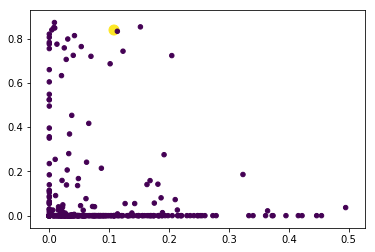

In [166]:
colors = [20] * doc_vectors.shape[0]
colors[0] = 100;
plt.scatter(df['united'], df['climate'], c=colors, s=colors)
plt.show()

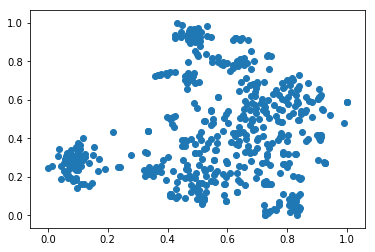

In [159]:
###############################################
# Reduce Dimensionality
###############################################
#https://distill.pub/2016/misread-tsne/

#dimension_reducer = decomposition.PCA(n_components=2)
#dimension_reducer = manifold.Isomap(10, eigen_solver='auto', n_components=2)
dimension_reducer = manifold.TSNE(perplexity=min(round(3 + doc_vectors.shape[0]/10), 50))
#dimension_reducer = decomposition.TruncatedSVD() # doesn't require dense matrix

doc_points = dimension_reducer.fit_transform(doc_vectors)

# dimension_reducer1 = decomposition.TruncatedSVD(n_components=100) # set tfidf features to 10000+
# dimension_reducer2 = manifold.TSNE(perplexity=min(round(3 + doc_vectors.shape[0]/10), 50))
# doc_vectors_reduced = dimension_reducer1.fit_transform(doc_vectors)
# doc_points = dimension_reducer2.fit_transform(doc_vectors_reduced)

doc_points = preprocessing.minmax_scale(doc_points)

plt.scatter(doc_points[:, 0], doc_points[:, 1])
plt.show()

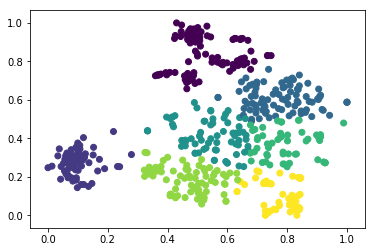

In [167]:
###############################################
# Assign Documents to Clusters
###############################################
#http://scikit-learn.org/stable/modules/clustering.html

def find_centers(points, point_labels):
    labels  = np.unique(point_labels)
    return {label: np.mean(points[point_labels==label], axis=0) for label in labels}

cluster_alg = cluster.AffinityPropagation(preference=-1, damping=0.7)

#cluster_alg = cluster.DBSCAN(eps=0.06, min_samples=round(doc_points.shape[0] / 40))

#cluster_alg = cluster.MeanShift(bin_seeding=True)

cluster_alg.fit(doc_points);

cluster_centers = find_centers(doc_points, cluster_alg.labels_)
#cluster_centers = cluster_alg.cluster_centers_

plt.scatter(doc_points[:, 0], doc_points[:, 1], c=cluster_alg.labels_);
plt.show()

In [168]:
###############################################
# Additional Metrics
###############################################

distances_from_center = np.array([])

for i, doc in enumerate(doc_points):
    center = cluster_centers[cluster_alg.labels_[i]]
    distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(doc, center)]))
    distances_from_center = np.append(distances_from_center, distance)

if distances_from_center.max() > 0:
    distances_from_center = distances_from_center/distances_from_center.max()

file_size_as_features = np.array(fileSize).reshape(-2, 1)
rel_file_size = preprocessing.QuantileTransformer(output_distribution='uniform').fit_transform(file_size_as_features)[:,0]

###############################################
# Serialize
###############################################


docs = [{
    'x': float(doc[0]), 
    'y': float(doc[1]),
    'cluster': int(cluster_alg.labels_[i]),
    'name': fileNames[i], 
    'size': rel_file_size[i],
    'distanceFromCenter': distances_from_center[i]
} for i, doc in enumerate(doc_points)]

with open('docs.json', 'w') as outfile:
    json.dump(docs, outfile)